In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import IPython
import librosa
import librosa.display
from tqdm import tqdm_notebook
from sklearn.model_selection import StratifiedKFold


%matplotlib inline

COMPLETE_RUN = True
data_path = '../data'

In [2]:
train_curated = pd.read_csv(data_path + "/train_curated.csv")
train_noisy = pd.read_csv(data_path + "/train_noisy.csv")

In [138]:
test = pd.read_csv(data_path + "/sample_submission.csv")

In [3]:
train_curated.sample(5)

fname                              labels
3968  cc4f25e2.wav  Sink_(filling_or_washing),Gurgling
3425  b187ef20.wav              Walk_and_footsteps,Run
3647  bc687b7d.wav                         Church_bell
1357  46bd52a4.wav                       Keys_jangling
2988  9b10744d.wav                       Raindrop,Drip

In [4]:
train_noisy.sample(5)

fname              labels
15476  c79fd58f.wav             Shatter
5183   42b20526.wav             Printer
3892   31b818d1.wav  Fill_(with_liquid)
14318  b80bc2fd.wav         Bass_guitar
10346  854ec3a7.wav             Printer

In [5]:
print("Number of train curated examples=", train_curated.shape[0], "  Number of classes=", len(set(train_curated['labels'])))
print("Number of train noisy examples=", train_noisy.shape[0], "  Number of classes=", len(set(train_noisy['labels'])))
print("Number of test examples=", test.shape[0], "  Number of classes=", len(set(test.columns[1:])))

Number of train curated examples= 4970   Number of classes= 213
Number of train noisy examples= 19815   Number of classes= 1168
Number of test examples= 1120   Number of classes= 80


In [6]:
train_curated = train_curated[train_curated['labels'].isin(test.columns[1:])]
print(len(train_curated))

4269


In [7]:
train_noisy = train_noisy[train_noisy['labels'].isin(test.columns[1:])]
print(len(train_noisy))

16566


In [8]:
print("Curated dataset lost %{:.1f}".format((4970 - 4269)/4970 * 100))
print("Noisy dataset lost %{:.1f}".format((19815 - 16566)/19815 * 100))

Curated dataset lost %14.1
Noisy dataset lost %16.4


In [9]:
print("Number of train curated examples=", train_curated.shape[0], "  Number of classes=", len(set(train_curated['labels'])))
print("Number of train noisy examples=", train_noisy.shape[0], "  Number of classes=", len(set(train_noisy['labels'])))
print("Number of test examples=", test.shape[0], "  Number of classes=", len(set(test.columns[1:])))

Number of train curated examples= 4269   Number of classes= 74
Number of train noisy examples= 16566   Number of classes= 80
Number of test examples= 1120   Number of classes= 80


In [10]:
def read_audio(conf, pathname, trim_long_data):
    y, sr = librosa.load(pathname, sr=conf.sampling_rate)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data:
            y = y[0:0+conf.samples]
    else: # pad blank
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
    return y

def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

def show_melspectrogram(conf, mels, title='Log-frequency power spectrogram'):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', 
                             sr=conf.sampling_rate, hop_length=conf.hop_length,
                            fmin=conf.fmin, fmax=conf.fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

def read_as_melspectrogram(conf, pathname, trim_long_data, debug_display=False):
    x = read_audio(conf, pathname, trim_long_data)
    mels = audio_to_melspectrogram(conf, x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
        show_melspectrogram(conf, mels)
    return mels


class Conf:
    # Preprocessing settings
    sampling_rate = 44100
    duration = 2
    hop_length = 347*duration # to make time steps 128
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    samples = sampling_rate * duration

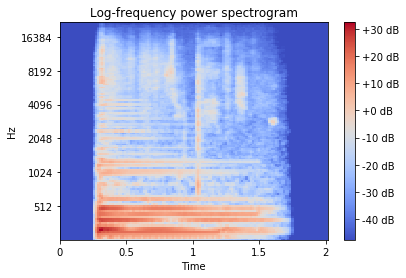

In [11]:
# example
x1 = read_as_melspectrogram(Conf, data_path + '/train_curated/7589c133.wav', trim_long_data=False, debug_display=True)

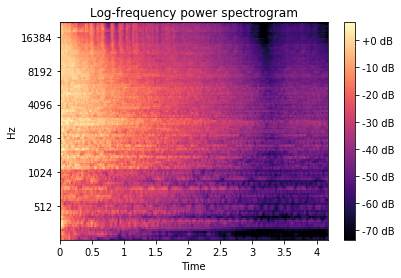

In [12]:
# example 2
x2 = read_as_melspectrogram(Conf, data_path + '/train_curated/00ffa0d2.wav', trim_long_data=False, debug_display=True)

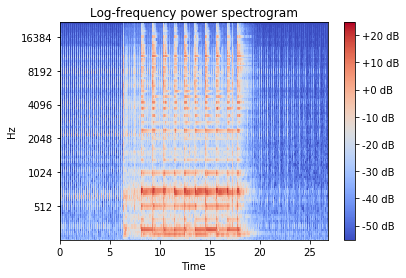

In [13]:
# example 3
x2 = read_as_melspectrogram(Conf, data_path + '/train_curated/ffd4ed26.wav', trim_long_data=False, debug_display=True)

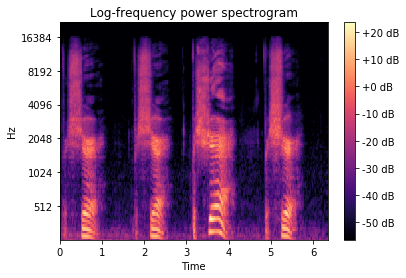

In [14]:
# example 4
x2 = read_as_melspectrogram(Conf, data_path + '/train_curated/cb943fba.wav', trim_long_data=False, debug_display=True)

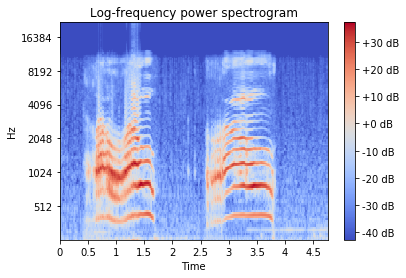

In [96]:
# example 2
x2 = read_as_melspectrogram(Conf, data_path + '/train_curated/45e821c3.wav', trim_long_data=False, debug_display=True)

In [16]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Scale to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

def convert_wav_to_image(df, source, img_dest):
    X = []
    for i, row in tqdm_notebook(df.iterrows()):
        x = read_as_melspectrogram(Conf, source + '/' + str(row.fname), trim_long_data=False)
        x_color = mono_to_color(x)
        X.append(x_color)
    # img_dest unused for now
    return X

In [17]:
train_curated_path = data_path + '/train_curated'
train_curated_images_path = data_path + '/train_nosiy_images'
train_noisy_path = data_path + '/train_noisy'
train_noisy_images_path = data_path + '/train_noisy_images'
test_path = data_path + '/test'
test_images_path = data_path + '/test_images'

X_train_curated = convert_wav_to_image(train_curated, source=train_curated_path, img_dest=train_curated_images_path)
X_train_noisy = convert_wav_to_image(train_noisy, source=train_noisy_path, img_dest=train_noisy_images_path)
X_test = convert_wav_to_image(test, source=test_path, img_dest=test_images_path)

In [ ]:
import PIL
import random

CUR_X_FILES, CUR_X = list(train_curated.fname.values), X_train_curated
print(CUR_X_FILES[0], CUR_X[0].shape)

def pil2tensor(image, dtype):
    a = np.asarray(image)
    if a.ndim==2 : a = np.expand_dims(a,2)    
    a = np.transpose(a, (1, 0, 2))  #transpose width, height to height,width
    a = np.transpose(a, (2, 1, 0))  #move channels to the first positionf
    return a.astype(dtype, copy=False)
    # return torch.from_numpy( a.astype(dtype, copy=False) )

def open_image(fn)->PIL.Image:
    filename = fn.split('/')[-1]
    idx = CUR_X_FILES.index(filename)
    x = PIL.Image.fromarray(CUR_X[idx])
    time_dim, base_dim = x.size
    return x.resize((256,256))

In [ ]:
open_image(data_path + '/train_curated/cb943fba.wav')

In [211]:
np.array(open_image(data_path + '/train_curated/45e821c3.wav').getdata())

... (128, 302, 3)


array([[139, 139, 139],
       [119, 119, 119],
       [ 87,  87,  87],
       ...,
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0]])

In [ ]:
# alternatively use cv2
import cv2

fig = plt.figure(figsize=(40,5))
ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
iii = cv2.resize(CUR_X[10], (256,256))

ax.imshow(iii);

In [128]:
from keras import losses, models, optimizers
from keras.layers import (Input, Dense, Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, GlobalMaxPool2D, MaxPool2D, concatenate, Activation)
from keras.utils import Sequence, to_categorical
from keras import backend as K
from keras.callbacks import (EarlyStopping, ModelCheckpoint, TensorBoard)
from keras.activations import relu, softmax

category_group = train_noisy.groupby(['labels']).count() # there are a few more labels in noisy than in curated
category_group.columns = ['counts']
print(len(category_group))

COMPLETE_RUN = False

category_group.head()

80


counts
labels                                    
Accelerating_and_revving_and_vroom     250
Accordion                              261
Acoustic_guitar                        249
Applause                               254
Bark                                   257

In [134]:
train_curated.head(1)

fname labels
0  0006ae4e.wav   Bark

In [133]:
train_noisy.head(1)

fname                        labels
0  00097e21.wav  Bathtub_(filling_or_washing)

In [198]:
class Config(object):
    def __init__(self,
                 n_classes=len(category_group),
                 use_mfcc=False,
                 n_folds=10,
                 learning_rate=0.0001, 
                 max_epochs=50,
                 n_mfcc=20):
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

In [160]:
def get_2d_dummy_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = GlobalMaxPool2D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

def get_2d_conv_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [161]:
LABELS = list(train_noisy['labels'].unique())
label_idx = {label: i for i, label in enumerate(LABELS)}

train_curated_ = train_curated.set_index("fname")
train_noisy_ = train_noisy.set_index("fname")
test_ = test.set_index("fname")

train_curated_["label_idx"] = train_curated_['labels'].apply(lambda x: label_idx[x])
train_noisy_["label_idx"] = train_noisy_['labels'].apply(lambda x: label_idx[x])

if not COMPLETE_RUN:
    train = train[:2000]
    test = test[:2000]

In [178]:
train_noisy_.head(1)

labels  label_idx
fname                                                
00097e21.wav  Bathtub_(filling_or_washing)          0

In [185]:
config = Config(sampling_rate=44100, audio_duration=2, n_folds=10, 
                learning_rate=0.001, use_mfcc=False, n_mfcc=40)
if not COMPLETE_RUN:
    config = Config(sampling_rate=44100, audio_duration=2, n_folds=2, 
                    max_epochs=1, use_mfcc=False, n_mfcc=40)

In [186]:
def prepare_data(df, config, data_dir):
    X = np.empty(shape=(df.shape[0], config.dim[0], config.dim[1], 1))
    input_length = config.audio_length
    for i, fname in enumerate(df.index):
        file_path = data_dir + fname
        # data, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")
        data = open_image(file_path)
        print(data.shape)
        
        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

        data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
        data = np.expand_dims(data, axis=-1)
        X[i,] = data
    return X

In [190]:
%time
X_train = prepare_data(train_noisy_, config, data_path + '/train_noisy/')
X_test = prepare_data(test, config, data_path + '/test/')
y_train = to_categorical(train_noisy_.label_Fidx.astype('str'), num_classes=config.n_classes)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs
../data/train_noisy/00097e21.wav


ValueError: could not broadcast input array from shape (40,173,1) into shape (88200,1,1)

In [166]:
# Normalize data
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

NameError: name 'X_train' is not defined

In [188]:
# Training 2D Conv on Mel-Spectogram

PREDICTION_FOLDER = "predictions_2d_conv"
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)

skf = StratifiedKFold(n_splits=config.n_folds)

for i, (train_split, val_split) in enumerate(skf.split(train_noisy_.index, train_noisy_.label_idx)):
    K.clear_session()
    X, y, X_val, y_val = X_train[train_split], y_train[train_split], X_train[val_split], y_train[val_split]
    checkpoint = ModelCheckpoint('best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%i'%i, write_graph=True)
    callbacks_list = [checkpoint, early, tb]
    print("#"*50)
    print("Fold: ", i)
    model = get_2d_conv_model(config)
    history = model.fit(X, y, validation_data=(X_val, y_val), callbacks=callbacks_list, 
                        batch_size=64, epochs=config.max_epochs)
    model.load_weights('best_%d.h5'%i)

    # Save train predictions
    predictions = model.predict(X_train, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)

    # Save test predictions
    predictions = model.predict(X_test, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)

    # Make a submission file
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test['label'] = predicted_labels
    test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)

NameError: name 'X_train' is not defined

In [ ]:
# # Ensembling 2D Conv Predictions¶

# pred_list = []
# for i in range(config.n_folds):
#     pred_list.append(np.load("./predictions_2d_conv/test_predictions_%d.npy"%i))
# prediction = np.ones_like(pred_list[0])
# for pred in pred_list:
#     prediction = prediction*pred
# prediction = prediction**(1./len(pred_list))
# # Make a submission file
# top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
# predicted_labels = [' '.join(list(x)) for x in top_3]
# test = pd.read_csv(data_path + '/sample_submission.csv')
# test['label'] = predicted_labels
# test[['fname', 'label']].to_csv("2d_conv_ensembled_noisy_submission.csv", index=False)